In [50]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Parallel processing comparation between OpenMP, CUDA and MPI
#### Cargamos el resultado de los benchmark

In [91]:
col = ("test250", "test500", "test750", "test1", "test2", "test3", "test4")
scol = [str(i) for i in range(1,6)]

row =  ("seq", "omp", "cuda", "mpi")

srow = ("cycles", "real_time_nsec", "PAPI_TOT_INS", "PAPI_TOT_CYC")

mcol = pd.MultiIndex.from_product([col,scol])
mrow = pd.MultiIndex.from_product([row,srow])

df = pd.DataFrame(np.loadtxt("test2.csv", delimiter=','), index=mrow, columns=mcol)

gmean = pd.DataFrame(np.full((mrow.size, len(col)), np.nan), index=mrow, columns=col)
for c in col:
    gmean[c] = df[c].aggregate(lambda ite: ite.prod()**(1/len(ite)), axis="columns")

gmean

test250       test500       test750         test1  \
seq  cycles          1.673399e+08  1.376655e+09  5.092946e+09  1.457238e+10   
     real_time_nsec  5.232206e+07  4.304562e+08  1.592481e+09  4.556548e+09   
     PAPI_TOT_INS    4.075696e+08  3.255260e+09  1.098058e+10  2.602102e+10   
     PAPI_TOT_CYC    1.739670e+08  1.435232e+09  5.327259e+09  1.530297e+10   
omp  cycles          4.422851e+07  3.666413e+08  1.346668e+09  3.468352e+09   
     real_time_nsec  1.382551e+07  1.146330e+08  4.210542e+08  1.084430e+09   
     PAPI_TOT_INS    1.062253e+08  8.464580e+08  2.851211e+09  6.756801e+09   
     PAPI_TOT_CYC    4.361244e+07  3.530835e+08  1.329132e+09  3.384548e+09   
cuda cycles          5.837907e+08  6.558106e+08  1.552956e+09  3.287576e+09   
     real_time_nsec  1.825321e+08  2.050514e+08  4.855633e+08  1.027931e+09   
     PAPI_TOT_INS    1.604718e+08  1.022733e+09  2.955572e+09  6.550140e+09   
     PAPI_TOT_CYC    8.669255e+07  5.134805e+08  1.461579e+09  3.276757e+09   
mpi  cycles          3.269979e+08  9.390821e+08  2.434116e+09  3.248026e+09   
     real_time_nsec  1.022435e+08  2.936254e+08  7.610854e+08  1.015574e+09   
     PAPI_TOT_INS    1.403846e+08  4.771940e+08  1.297272e+09  2.708989e+09   
     PAPI_TOT_CYC    9.279145e+07  3.045043e+08  1.145632e+09  1.676783e+09   

                            test2         test3         test4  
seq  cycles          1.261500e+11  4.311329e+11  1.244407e+12  
     real_time_nsec  3.944507e+10  1.348084e+11  3.890939e+11  
     PAPI_TOT_INS    2.080841e+11  7.021892e+11  1.664336e+12  
     PAPI_TOT_CYC    1.326637e+11  4.534211e+11  1.308065e+12  
omp  cycles          3.229357e+10  9.994429e+10  3.407191e+11  
     real_time_nsec  1.009707e+10  3.124921e+10  1.065325e+11  
     PAPI_TOT_INS    5.402455e+10  1.823004e+11  4.320899e+11  
     PAPI_TOT_CYC    3.184422e+10  9.833460e+10  3.348743e+11  
cuda cycles          2.487972e+10  8.317440e+10  1.969748e+11  
     real_time_nsec  7.779189e+09  2.600635e+10  6.158883e+10  
     PAPI_TOT_INS    5.334167e+10  1.839452e+11  4.231024e+11  
     PAPI_TOT_CYC    2.598267e+10  8.738334e+10  2.066958e+11  
mpi  cycles          2.601085e+10  9.454347e+10  3.525552e+11  
     real_time_nsec  8.132935e+09  2.956139e+10  1.102357e+11  
     PAPI_TOT_INS    2.119568e+10  7.346474e+10  1.858146e+11  
     PAPI_TOT_CYC    1.401641e+10  4.395291e+10  1.741533e+11

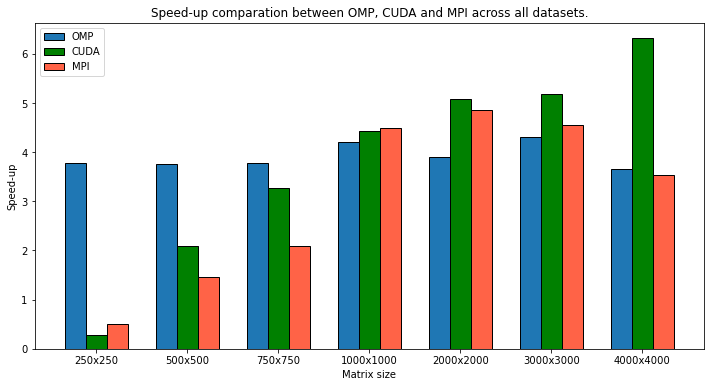

In [92]:
omp_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["omp", "real_time_nsec"])
cuda_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["cuda", "real_time_nsec"])
mpi_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["mpi", "real_time_nsec"])

width = 0.23
xaxis = np.arange(omp_sp.size)

fig, ax = plt.subplots()

xlabel = ['250x250', '500x500', '750x750', '1000x1000', '2000x2000', '3000x3000', '4000x4000']

ax.bar(xaxis - width, omp_sp, width,label='OMP', edgecolor='black')
ax.bar(xaxis, cuda_sp, width, color="green", tick_label=xlabel, label='CUDA', edgecolor='black')
ax.bar(xaxis + width, mpi_sp, width, color="tomato", label='MPI', edgecolor='black')

ax.set_title("Speed-up comparation between OMP, CUDA and MPI across all datasets.")
ax.set_ylabel("Speed-up")
ax.set_xlabel("Matrix size")
ax.legend()

fig.set_size_inches((12,6))

plt.show()
